# Location mention recognision program

## Import libraries 

In [1]:
import os
import torch
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForTokenClassification
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch.optim import AdamW


## Import data

In [2]:
df = pd.read_csv("Train_1.csv")

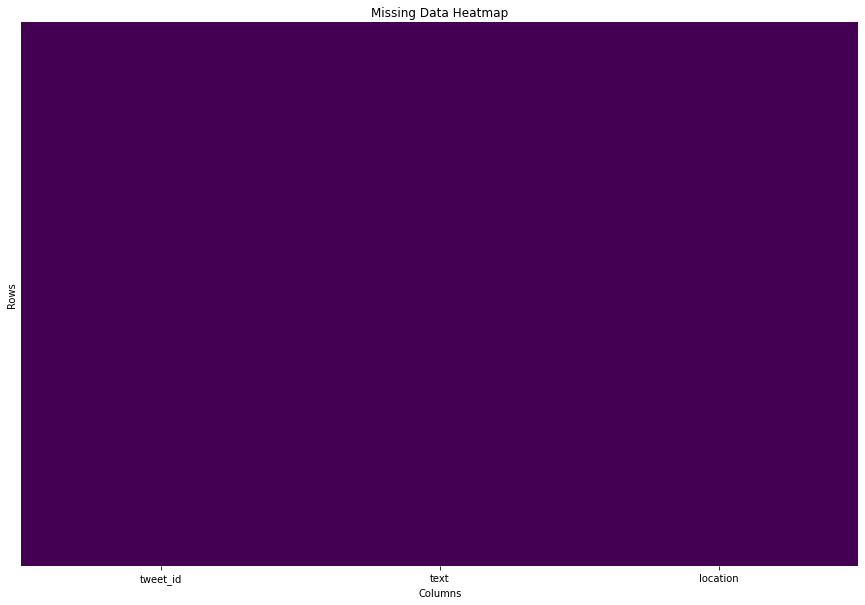

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Use a heatmap to visualize missing data
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)

# Add labels and a title
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.title("Missing Data Heatmap")

# Show the plot
plt.show()

In [8]:
print(df.isnull().sum())

tweet_id    0
text        0
location    0
dtype: int64


In [9]:
print(df["tweet_id"].count())

11849


In [6]:
df = df.dropna()

In [10]:
import re

# Function to clean text
def clean_text(text):
    # 1. Lowercase the text
    text = text.lower()
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # 3. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # 4. Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # 5. Remove mentions
    text = re.sub(r'@\w+', '', text)
    # 6. Remove special characters, punctuation, and numbers (including ":" and "@")
    text = re.sub(r'[^\w\s.,!?]', '', text)  # Keeps only alphanumeric characters, spaces, and punctuation
    # 7. Remove any standalone punctuation like ':' or '@'
    text = re.sub(r'[:@]', '', text)
    # 8. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply cleaning function to the microblogs
df['text'] = df['text'].apply(clean_text)
print(df['text'])


1        flash floods struck a maryland city on sunday,...
2        state of emergency declared for maryland flood...
3        other parts of maryland also saw significant d...
4        catastrophic flooding slams ellicott city, mar...
5        watch 1 missing after flash devastates ellicot...
                               ...                        
73066    mexico city at least a thousand buildings dama...
73068    rescue workers recover the body of the last pe...
73069    donate from facebook to mexico earthquake reli...
73070    we are helping our clients in mexico recover f...
73071    thanks for the support! like them you can dona...
Name: text, Length: 11849, dtype: object


In [19]:
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
import pandas as pd
from tqdm import tqdm

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Step 1: Function to create BIO labels with subword handling
def create_bio_labels(text, location):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)
    
    # Initialize labels as 'O' (non-location)
    bio_labels = ['O'] * len(tokens)
    
    # Tokenize the location for matching
    location_tokens = tokenizer.tokenize(location)

    # Try to find the location tokens in the text tokens
    for i in range(len(tokens) - len(location_tokens) + 1):
        if tokens[i:i + len(location_tokens)] == location_tokens:
            # Mark the first token of the location as B-LOC and the rest as I-LOC
            bio_labels[i] = 'B-LOC'
            for j in range(1, len(location_tokens)):
                bio_labels[i + j] = 'I-LOC'
    
    return tokens, bio_labels

In [20]:
# Step 2: Handle subword tokenization and label adjustment
def tokenize_and_align_labels(text, location, tokenizer, label_encoder):
    tokens, bio_labels = create_bio_labels(text, location)
    
    input_ids = []
    label_ids = []

    for word, label in zip(tokens, bio_labels):
        # Tokenize the word (it may break into multiple subwords)
        word_tokens = tokenizer.tokenize(word)
        
        # Convert the tokens to input IDs
        word_ids = tokenizer.convert_tokens_to_ids(word_tokens)
        
        # Append the input IDs
        input_ids.extend(word_ids)
        
        # Adjust labels: the first subword gets the original label, others get 'I-LOC' or 'O'
        if label == 'B-LOC':  # Location start
            subword_labels = [label] + ['I-LOC'] * (len(word_tokens) - 1)
        else:
            subword_labels = [label] + ['O'] * (len(word_tokens) - 1)
        
        # Transform BIO string labels to numerical labels using the label encoder
        label_ids.extend(label_encoder.transform(subword_labels))

    return input_ids, label_ids



In [21]:
# Step 3: Initialize and fit the LabelEncoder with the BIO labels
label_encoder = LabelEncoder()
label_encoder.fit(['O', 'B-LOC', 'I-LOC'])  # Fit the label encoder with the BIO tags

# Step 4: Apply the tokenization and label alignment to each tweet
all_input_ids = []
all_label_ids = []

print("Processing dataset and aligning tokens with BIO labels...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    input_ids, label_ids = tokenize_and_align_labels(row['text'], row['location'], tokenizer, label_encoder)
    all_input_ids.append(input_ids)
    all_label_ids.append(label_ids)


Processing dataset and aligning tokens with BIO labels...


100%|███████████████████████████████████████████████████████████████████████████| 11849/11849 [00:30<00:00, 382.62it/s]


In [22]:
# Step 4: Padding and converting to tensors
max_len = 50  # Maximum sequence length

# Pad tokens and labels
def pad_sequences(sequences, max_len, pad_value=0):
    padded_seqs = []
    for seq in sequences:
        if len(seq) < max_len:
            padded_seq = seq + [pad_value] * (max_len - len(seq))
        else:
            padded_seq = seq[:max_len]
        padded_seqs.append(padded_seq)
    return padded_seqs

print("Padding tokens and BIO labels...")

# Check that all_input_ids and all_label_ids contain numerical values
print(f"Example input IDs (before padding): {all_input_ids[0]}")
print(f"Example label IDs (before padding): {all_label_ids[0]}")

# Pad input IDs and labels to max_len
input_ids_padded = pad_sequences(all_input_ids, max_len, pad_value=tokenizer.pad_token_id)
bio_labels_padded = pad_sequences(all_label_ids, max_len, pad_value=label_encoder.transform(['O'])[0])

# Convert to tensors
input_ids_tensor = torch.tensor(input_ids_padded, dtype=torch.long)
bio_labels_tensor = torch.tensor(bio_labels_padded, dtype=torch.long)

# Create attention masks (1 for real tokens, 0 for padding)
attention_masks = [[float(i != tokenizer.pad_token_id) for i in seq] for seq in input_ids_padded]
attention_masks_tensor = torch.tensor(attention_masks, dtype=torch.float)

# Final output: input_ids_tensor, bio_labels_tensor, attention_masks_tensor
print(f"Input IDs shape: {input_ids_tensor.shape}")
print(f"BIO Labels shape: {bio_labels_tensor.shape}")
print(f"Attention Masks shape: {attention_masks_tensor.shape}")

# Example of tokenization and BIO labeling
for i, tokens in enumerate(all_input_ids[:1]):
    print("\nOriginal tokens:", tokenizer.convert_ids_to_tokens(tokens))
    print("Original BIO labels:", all_label_ids[i])
    print("Input IDs:", input_ids_tensor[i])
    print("BIO label IDs:", bio_labels_tensor[i])
    print("Attention Mask:", attention_masks_tensor[i])

Padding tokens and BIO labels...
Example input IDs (before padding): [5956, 14295, 4930, 1037, 5374, 2103, 2006, 4465, 1010, 12699, 2041, 4534, 1998, 15021, 3765, 2066, 7198, 10899, 1012]
Example label IDs (before padding): [2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Input IDs shape: torch.Size([11849, 50])
BIO Labels shape: torch.Size([11849, 50])
Attention Masks shape: torch.Size([11849, 50])

Original tokens: ['flash', 'floods', 'struck', 'a', 'maryland', 'city', 'on', 'sunday', ',', 'washing', 'out', 'streets', 'and', 'tossing', 'cars', 'like', 'bath', 'toys', '.']
Original BIO labels: [2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Input IDs: tensor([ 5956, 14295,  4930,  1037,  5374,  2103,  2006,  4465,  1010, 12699,
         2041,  4534,  1998, 15021,  3765,  2066,  7198, 10899,  1012,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
        

In [23]:
# Step 7: Train/test split with progress bar
print("Splitting data into training and testing sets...")
train_inputs, test_inputs, train_masks, test_masks, train_labels, test_labels = train_test_split(
    input_ids_tensor, attention_masks_tensor, bio_labels_tensor, test_size=0.1, random_state=42
)


Splitting data into training and testing sets...


In [24]:
# Step 8: Move data to device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_inputs = train_inputs.to(device)
test_inputs = test_inputs.to(device)
train_masks = train_masks.to(device)
test_masks = test_masks.to(device)
train_labels = train_labels.to(device)
test_labels = test_labels.to(device)

# Step 9: Create dataloaders
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
test_data = TensorDataset(test_inputs, test_masks, test_labels)

train_sampler = RandomSampler(train_data)
test_sampler = SequentialSampler(test_data)

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [25]:
# Step 10: Initialize the BERT model for token classification
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
model = model.to(device)

# Step 11: Use AdamW optimizer with weight decay for better generalization
optimizer = AdamW(model.parameters(), lr=1e-5)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [26]:
# Step 12: Training function with progress bar
def train_model(model, train_dataloader, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        total_loss = 0
        for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):
            batch_input_ids, batch_attention_masks, batch_labels = tuple(t.to(device) for t in batch)
            
            model.zero_grad()
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
        
        avg_loss = total_loss / len(train_dataloader)
        print(f"Average loss: {avg_loss:.4f}")




In [27]:

# Step 13: Fine-tuning the BERT model
train_model(model, train_dataloader, optimizer)


Epoch 1/3


Training Epoch 1: 100%|████████████████████████████████████████████████████████████| 334/334 [1:03:18<00:00, 11.37s/it]


Average loss: 0.0756
Epoch 2/3


Training Epoch 2: 100%|████████████████████████████████████████████████████████████| 334/334 [1:03:34<00:00, 11.42s/it]


Average loss: 0.0270
Epoch 3/3


Training Epoch 3: 100%|████████████████████████████████████████████████████████████| 334/334 [1:03:15<00:00, 11.36s/it]

Average loss: 0.0201


In [28]:
# Step 14: Prediction and converting logits to labels with progress bar
def convert_logits_to_labels_batch(predictions, label_encoder, input_ids, attention_masks, batch_size=32):
    predicted_labels = []
    num_batches = int(np.ceil(len(predictions) / batch_size))
    
    for i in tqdm(range(num_batches), desc="Converting logits to labels"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(predictions))
        
        batch_predictions = predictions[start_idx:end_idx]
        batch_input_ids = input_ids[start_idx:end_idx]
        batch_attention_masks = attention_masks[start_idx:end_idx]
        
        softmax_predictions = torch.nn.functional.softmax(torch.tensor(batch_predictions), dim=2).numpy()
        predicted_indices = np.argmax(softmax_predictions, axis=2)
        
        batch_predicted_labels = []
        for idx, (pred_labels, input_id, attention_mask) in enumerate(zip(predicted_indices, batch_input_ids, batch_attention_masks)):
            # Cleaning and transforming predicted labels back to their original string labels
            cleaned_labels = [label_encoder.inverse_transform([label])[0] for label, mask in zip(pred_labels, attention_mask) if mask == 1]
            batch_predicted_labels.append(cleaned_labels)
        
        predicted_labels.extend(batch_predicted_labels)
    
    return predicted_labels

In [29]:
# Step 15: Save the trained model, tokenizer, and label encoder
output_dir = "./model_save/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
with open(os.path.join(output_dir, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(label_encoder, f)


In [30]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Step 16: Function for model evaluation on the test dataset
def evaluate_model(model, test_dataloader, label_encoder):
    model.eval()  # Put model in evaluation mode
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():  # Disable gradient calculation for faster evaluation
        for batch in tqdm(test_dataloader, desc="Evaluating"):
            batch_input_ids, batch_attention_masks, batch_labels = tuple(t.to(device) for t in batch)

            # Get model outputs (logits)
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
            logits = outputs.logits

            # Convert logits to predicted labels
            predictions = torch.argmax(logits, dim=2).cpu().numpy()

            # Remove padding and gather true labels and predictions
            batch_labels = batch_labels.cpu().numpy()
            batch_attention_masks = batch_attention_masks.cpu().numpy()

            for pred, true, mask in zip(predictions, batch_labels, batch_attention_masks):
                true_labels = true[mask == 1]  # Ignore padding tokens
                predicted_labels = pred[mask == 1]  # Ignore padding tokens
                all_true_labels.extend(true_labels)
                all_predictions.extend(predicted_labels)

    # Convert numeric labels back to string labels
    all_true_labels = label_encoder.inverse_transform(all_true_labels)
    all_predictions = label_encoder.inverse_transform(all_predictions)

    return all_true_labels, all_predictions

# Step 17: Evaluate the model
true_labels, predicted_labels = evaluate_model(model, test_dataloader, label_encoder)

# Step 18: Generate the classification report
print("Generating evaluation metrics...")

# Flatten the labels to get rid of nested structure and print the classification report
print(classification_report(true_labels, predicted_labels, labels=label_encoder.classes_, zero_division=0))

# Accuracy score
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [02:15<00:00,  3.55s/it]


Generating evaluation metrics...
              precision    recall  f1-score   support

       B-LOC       0.80      0.91      0.85       785
       I-LOC       0.63      0.83      0.72       375
           O       1.00      0.99      0.99     31117

    accuracy                           0.98     32277
   macro avg       0.81      0.91      0.85     32277
weighted avg       0.99      0.98      0.99     32277

Accuracy: 0.9849


In [31]:
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertForTokenClassification
from tqdm import tqdm
import os
import pickle

# Step 1: Load the pre-trained model, tokenizer, and label encoder
output_dir = "./model_save/"

model = BertForTokenClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

with open(os.path.join(output_dir, 'label_encoder.pkl'), 'rb') as f:
    label_encoder = pickle.load(f)

model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model.eval()  # Set the model to evaluation mode

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [32]:

# Step 2: Preprocess the new tweets
def preprocess_tweets(new_tweets, tokenizer, max_len=50):
    all_tokens = []
    attention_masks = []

    for tweet in new_tweets:
        # Tokenize the tweet
        tokens = tokenizer.tokenize(tweet)
        tokens = ['[CLS]'] + tokens + ['[SEP]']  # Add special tokens
        
        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        
        # Create attention masks (1 for actual tokens, 0 for padding)
        attention_mask = [1] * len(input_ids)

        # Pad tokens and attention mask to max_len
        input_ids = input_ids[:max_len] + [tokenizer.pad_token_id] * (max_len - len(input_ids))
        attention_mask = attention_mask[:max_len] + [0] * (max_len - len(attention_mask))

        all_tokens.append(input_ids)
        attention_masks.append(attention_mask)

    return torch.tensor(all_tokens), torch.tensor(attention_masks)

In [33]:
# Step 3: Predict the BIO labels for new tweets
def predict_bio_labels(model, tokenizer, new_tweets, label_encoder, batch_size=32):
    input_ids, attention_masks = preprocess_tweets(new_tweets, tokenizer)
    input_ids, attention_masks = input_ids.to(model.device), attention_masks.to(model.device)

    predictions = []
    with torch.no_grad():
        for i in tqdm(range(0, len(input_ids), batch_size), desc="Predicting BIO labels"):
            batch_input_ids = input_ids[i:i + batch_size]
            batch_attention_masks = attention_masks[i:i + batch_size]

            # Get model predictions (logits)
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
            logits = outputs.logits

            # Convert logits to predicted label IDs
            batch_predictions = torch.argmax(logits, dim=2).cpu().numpy()

            predictions.extend(batch_predictions)

    # Convert predicted label IDs to BIO labels
    predicted_bio_labels = []
    for pred in predictions:
        predicted_labels = label_encoder.inverse_transform(pred)
        predicted_bio_labels.append(predicted_labels)

    return predicted_bio_labels

In [34]:
# Step 4: Extract locations from predicted BIO labels
def extract_locations(new_tweets, predicted_bio_labels):
    extracted_locations = []
    for tweet, bio_labels in zip(new_tweets, predicted_bio_labels):
        tokens = tokenizer.tokenize(tweet)
        locations = []
        current_location = None

        for token, label in zip(tokens, bio_labels):
            if label.startswith("B-LOC"):  # Start of a location
                current_location = token
            elif label.startswith("I-LOC") and current_location:  # Continuation of the location
                current_location += " " + token
            else:
                if current_location:
                    locations.append(current_location)  # Add location to list
                    current_location = None

        if current_location:
            locations.append(current_location)

        extracted_locations.append(locations)

    return extracted_locations

In [35]:
import re

# Step 5: Read new tweets from a CSV file

data = pd.read_csv('Test.csv')


# Function to clean text
def clean_text(text):
    # 1. Lowercase the text
    text = text.lower()
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # 3. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # 4. Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # 5. Remove mentions
    text = re.sub(r'@\w+', '', text)
    # 6. Remove special characters, punctuation, and numbers (including ":" and "@")
    text = re.sub(r'[^\w\s.,!?]', '', text)  # Keeps only alphanumeric characters, spaces, and punctuation
    # 7. Remove any standalone punctuation like ':' or '@'
    text = re.sub(r'[:@]', '', text)
    # 8. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply cleaning function to the microblogs
data['text'] = data['text'].apply(clean_text)
print(data['text'])


0       what is happening to the infrastructure in new...
1       solder missing in flood.. pray for eddison her...
2       rt police searching for missing person after d...
3       flash flood tears through maryland town for se...
4       ellicott city pictures maryland governor decla...
                              ...                        
2937    he wants to donate some food to homeless cats ...
2938    i live the mexico earthquake and my house is d...
2939    rt watch national taco day in calgary to benef...
2940    oaxaca chiapas mexicos poorest states harshest...
2941    rt carlos santana donates 100k to mexico earth...
Name: text, Length: 2942, dtype: object


In [36]:

# Assuming the tweets are in a column named 'text'
new_tweets = data['text'].tolist()

# Step 6: Run the model on the new tweets
print("Extracting locations from new tweets...")
predicted_bio_labels = predict_bio_labels(model, tokenizer, new_tweets, label_encoder)
extracted_locations = extract_locations(new_tweets, predicted_bio_labels)




Extracting locations from new tweets...


Predicting BIO labels: 100%|███████████████████████████████████████████████████████████| 92/92 [05:38<00:00,  3.68s/it]


In [38]:
# Step 7: Add extracted locations to a new dataframe with only tweet_id and extracted locations
df_output = data[['tweet_id']].copy()  # Create a new dataframe with only the tweet_id column

# Convert list of extracted locations to a comma-separated string, and write "None" if empty
df_output['locations'] = ['; '.join(locations) if locations else 'None' for locations in extracted_locations]

# Save the results to a new CSV file with only the tweet_id and extracted_locations
output_csv_file = 'submission2.csv'
df_output.to_csv(output_csv_file, index=False)

print(f"Extracted locations saved to {output_csv_file}")

# Print a few results as an example
for tweet, locations in zip(new_tweets[:5], extracted_locations[:5]):
    print(f"Tweet: {tweet}")
    print(f"Extracted Locations: {', '.join(locations) if locations else 'None'}")
    print()


Extracted locations saved to submission2.csv
Tweet: what is happening to the infrastructure in new england? it isnt global warming, its misappropriated funds being abused that shouldve been used maintaining their infrastructure that couldve protected them from floods! like new orleans. their mayor went to ὄ7
Extracted Locations: orleans

Tweet: solder missing in flood.. pray for eddison hermond! pray for ellicott city, maryland!
Extracted Locations: None

Tweet: rt police searching for missing person after devastating 1,000year flood in ellicott city, maryland
Extracted Locations: None

Tweet: flash flood tears through maryland town for second time in two years less than two years after what had been called a once in a 1,000 years flood in 2016, ellicott city, md., sees its historic downtown ravaged anew. one man remains missing. from flas
Extracted Locations: None

Tweet: ellicott city pictures maryland governor declares state of emergency after severe flash
Extracted Locations: gover